In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.animation as animation
import math
import cvxopt
import copy
from control import matlab
import IPython
cvxopt.solvers.options['show_progress'] = False

In [2]:
class reference():
    
    def __init__(self, horizon_length,x_len, dt = 0.01):
        self.t = 0.
        self.x_ref = np.zeros((x_len,horizon_length))
        self.dt = dt
        self.l = horizon_length

        
    def update_reference(self):
        for i in range(self.l):
            self.x_ref[:, i] = np.array([[math.sin(self.t+self.dt*i)],
                                         [0],
                                         [0],
                                         [0]]).flatten()
        self.t += self.dt
            

In [3]:
def mpc_calculation(A, B, Q, R, x0, horizon, u_len, u_max, x_max, x_des):
    num_states = x0.size*horizon
    num_control = u_len*horizon
    num_vars = num_states+num_control
    
    # Contruction of required martrices
    Q1 = np.zeros([num_vars, num_vars])
    A1 = np.zeros([num_states, num_vars])
    b1 = np.zeros([num_states])
    b1[:x0.size] = -A.dot(x0).flatten()  
    
    q1 = np.zeros([num_vars])
    
    for i in range(horizon):
        Q1[x0.size*i:x0.size*(i+1), x0.size*i:x0.size*(i+1)] = Q
        Q1[num_states+u_len*i:num_states+u_len*(i+1),
           num_states+u_len*i:num_states+u_len*(i+1)] = R
        
        q1[x0.size*i:x0.size*(i+1)] = -x_des[:,i].dot(Q)
        A1[x0.size*i:x0.size*(i+1), num_states+u_len*i:num_states+u_len*(i+1)] = B
        if i>0:
            A1[x0.size*i:x0.size*(i+1), x0.size*(i-1):x0.size*(i+1)] = np.hstack((A, -np.eye(x0.size)))
        else:
            A1[x0.size*i:x0.size*(i+1), x0.size*(i):x0.size*(i+1)] = -np.eye(x0.size)
            
    G = np.zeros([2*num_control, num_vars])
    G[:, num_states:] = np.vstack((np.eye(num_control), -np.eye(num_control)))
    G = np.vstack((G, np.eye(num_states, num_vars)))
    G = np.vstack((G, -np.eye(num_states, num_vars)))
    h = np.vstack((np.tile(u_max, horizon), np.tile(u_max, horizon))).flatten()
    tt = np.vstack((np.tile(x_max, horizon), np.tile(x_max, horizon))).flatten()
    h = np.hstack((h.T, tt.T)).astype(float)
    Q = cvxopt.matrix(Q1)
    p = cvxopt.matrix(q1)
    G = cvxopt.matrix(G)
    h = cvxopt.matrix(h)
    A = cvxopt.matrix(A1)
    b = cvxopt.matrix(b1)
    sol = cvxopt.solvers.qp(Q, p, G, h, A, b)
    x = np.array(sol['x'])
    u = x[num_states:num_states+u_len]
    return u

In [4]:
class system():
    
    def __init__(self, A, B, C, D = None, init_states = None):
        
        self.A = A
        self.B = B
        self.C = C
        
        if D is not None:
            self.D = D
        
        self.x = np.zeros(self.A.shape[0])
        if init_states is not None:
            self.x = copy.deepcopy(init_states)
   
        self.his_x = [init_states]

        
        
    def update_state(self, u, dt = 0.01):
        self.temp_x = self.x.reshape(-1,1)
        self.temp_u = u.reshape(-1,1)
    
        # Calculating the coefficients for Range Kutta Method
        f1 = dt*(self.A.dot(self.temp_x)+self.B.dot(self.temp_u))
        f2 = dt*(self.A.dot(self.temp_x+f1/2)+ self.B.dot(self.temp_u))
        f3 = dt*(self.A.dot(self.temp_x+f2/2)+ self.B.dot(self.temp_u))
        f4 = dt*(self.A.dot(self.temp_x+f3)+ self.B.dot(self.temp_u))
        self.x = self.x + (f1+2*f2+2*f3+f4)/6
        temp_state = np.array(self.x)
        self.his_x.append(temp_state)

In [5]:
def main():
    dt = 0.05
    simulation_time = 30
    iter_num = int(simulation_time/dt)
    
    m = 1575
    Iz = 2875
    lf = 1.2
    lr = 1.6
    cf = 19000
    cr = 33000
    vx = 5
    
    A = np.array([[0, 1, 0, 0],
                 [0, -(cr+cf)/(m*vx), 0, -vx + (cr*lr-cf*lf)/(m*vx)],
                 [0, 0, 0, 1],
                 [0, (cf*lf-cr*lr)/Iz/vx,0, -(cr*lr**2+cf*lf**2)/(Iz*vx)]])
    
    B = np.array([[0],
                 [cf/(m)],
                 [0],
                 [cf*lf/Iz]])
    
    C = np.eye(4)
    
    D = np.zeros((4,1))
    
    # simulate the contiuous matrix
    init_x = np.array([[-.5], [0], [0], [0]])
    plant = system(A, B, C, init_states = init_x)
    
    # create the continuous system
    sys = matlab.ss(A, B, C, D)
    
    sysd = matlab.c2d(sys, dt)
    
    Ad = sysd.A
    Bd = sysd.B
    
    # Adding the wieght for the cost function
    Q = np.diag([100, 1, 1, 1])
    R = np.diag([1])
    horizon_length = 10
    input_limit = np.array([np.pi/4])
    x_max = np.array([1, 1, np.pi/4, np.pi/8])
    """
    The reference states for constant reference tracking is
    x_des = np.tile(np.array([[1],
                              [0],
                              [0],
                              [0]]), horizon_length)
    """
    ref1 = reference(horizon_length, len(A), dt = dt)
    u_len = len(B[0])
        
    for i in range(iter_num):
        states = plant.x.reshape(-1,1)
        ref1.update_reference()
        x_des = ref1.x_ref
        opt_u = mpc_calculation(Ad, Bd, Q, R, states, horizon_length, u_len, input_limit, x_max, x_des)
        if i%100 == 0:
            plant.x = np.array([[np.random.choice(np.linspace(-1,1,100),1)],[0],[0],[0]])
            plant.his_x.append(plant.x)
        else:
            plant.update_state(opt_u, dt = dt)
        
    his = np.array(plant.his_x)
    x1 = np.arange(0,simulation_time+dt,dt)
    y = []
    for i in x1:
        y.append(np.array([[np.sin(i)],[0],[0],[0]]))
    y = np.array(y)
    plt.figure(1, figsize=[15,10])
    plt.subplot(2,2,1)
    plt.plot(np.arange(0,simulation_time+dt,dt),his[:,0,:], np.arange(0,simulation_time+dt,dt), y[:,0])
    plt.xlabel('time')
    plt.ylabel('y')
    plt.legend(['States','Reference'], loc = 1)
    plt.subplot(2,2,2)
    plt.plot(np.arange(0,simulation_time+dt,dt),his[:,1,:], np.arange(0,simulation_time+dt,dt), y[:,1])
    plt.xlabel('time')
    plt.ylabel('$\dot{y}$')
    plt.legend(['States','Reference'], loc = 1)
    plt.subplot(2,2,3)
    plt.plot(np.arange(0,simulation_time+dt,dt),his[:,2,:], np.arange(0,simulation_time+dt,dt), y[:,2])
    plt.xlabel('time')
    plt.ylabel('$\psi$')
    plt.legend(['States','Reference'], loc = 1)
    plt.subplot(2,2,4)
    plt.plot(np.arange(0,simulation_time+dt,dt),his[:,3,:], np.arange(0,simulation_time+dt,dt), y[:,3])
    plt.xlabel('time')
    plt.ylabel('$\dot{\psi}$')
    plt.legend(['States','Reference'], loc = 1)

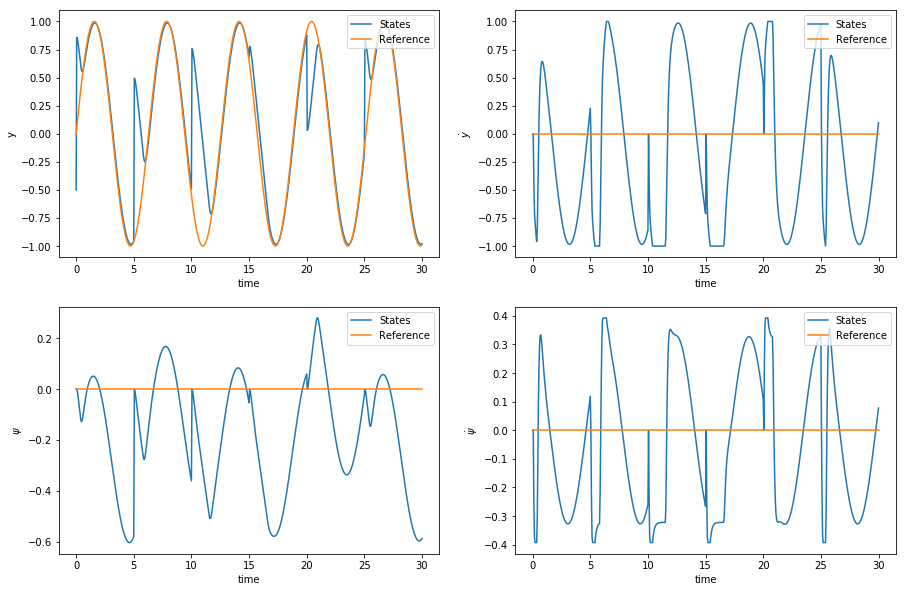

In [6]:
main()